# Predicting Q3 grades using Portuguese school grades datasets

## Overview

Analyze student data and create a machine learning model to predict third term student performance. The primary goal is to predict G3 grades without using grades from the first two semesters (G1 and G2).

I use Scitkit Learn to make Linear Regression, SVM Regression, Lasso Regression, Ridge Regression, and stacking ensemble method.

## Getting the Data, Importing Packages

In [133]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix

# Adding this to limit display and make it easier to see
pd.set_option('display.max_columns', 20)
import warnings
warnings.filterwarnings("ignore")

In [8]:
students = pd.read_csv("student-mat.csv", sep=';') #read in CSV

In [9]:
# Initial data check
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [ ]:
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [11]:
students.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [ ]:
# Correlations, have to convert columns to numeric to make the corr method work
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

students_numbered = students.replace({'yes': 1, 'no': 0, 'GP': 1, 'MS': 0, 'F': 1, 'M': 0, 'U': 1, 'R': 0, 'LE3': 0,
                                      'GT3': 1, 'T': 1, 'A': 0, "teacher": 4, "health": 3, "services": 2,
                                      "at_home": 1,"other": 0, "home": 3,"reputation": 2, "course": 1,
                                      "mother": 1, "father": 2})
students_numeric = students_numbered[["G3","Mjob","Fjob","reason","guardian","address","school","Pstatus","famsize","sex","romantic","schoolsup","famsup","paid","activities","nursery",
                                      "age","Medu","Fedu","famrel","traveltime","studytime","failures","higher",
                                      "internet","freetime","goout","Dalc","Walc","health","absences","G1","G2"]]
corr_matrix = students_numeric.corr()
corr_matrix
# variables over .1 correlation are: goout, failures, traveltime, Fedu, Medu, romantic, paid, age, higher, 
# address, sex, Mjob


,G3,Mjob,Fjob,reason,guardian,address,school,Pstatus,famsize,sex,romantic,schoolsup,famsup,paid,activities,nursery,age,Medu,Fedu,famrel,traveltime,studytime,failures,higher,internet,freetime,goout,Dalc,Walc,health,absences,G1,G2
G3,1.000000,0.145827,0.091128,0.008502,0.070109,0.105756,0.045017,-0.058009,-0.081407,-0.103456,-0.129970,-0.082788,-0.039157,0.101996,0.016100,0.051568,-0.161579,0.217147,0.152457,0.051363,-0.117142,0.097820,-0.360415,0.182465,0.098483,0.011307,-0.132791,-0.054660,-0.051939,-0.061335,0.034247,0.801468,0.904868
Mjob,0.145827,1.000000,0.309160,-0.059474,-0.036433,0.096169,0.065339,0.012711,-0.087041,-0.115762,-0.053560,-0.097495,0.142783,0.173602,0.129058,0.144967,-0.089558,0.535002,0.342174,-0.031130,-0.108535,-0.011124,-0.103623,0.075854,0.172439,0.073211,0.012494,0.003754,0.020245,0.051220,-0.023554,0.187996,0.155340
Fjob,0.091128,0.309160,1.000000,-0.085864,0.169888,0.055468,-0.012333,-0.020772,0.047132,0.004110,0.046987,0.074775,0.054606,-0.022754,0.036620,0.075106,-0.065816,0.215381,0.367789,-0.035101,-0.066387,0.021954,-0.007068,-0.019106,0.030656,-0.053002,-0.040243,0.056839,-0.066906,0.024784,-0.018386,0.152132,0.115121
reason,0.008502,-0.059474,-0.085864,1.000000,-0.030035,0.119302,0.126028,-0.036182,-0.000981,0.009822,-0.005050,0.015198,0.076230,0.086743,0.020747,0.044492,-0.005780,0.038195,0.017664,-0.005898,-0.088819,0.083898,0.010909,0.137866,0.069943,-0.111859,-0.017075,-0.079703,-0.060232,-0.070076,0.136277,0.031753,0.031470
guardian,0.070109,-0.036433,0.169888,-0.030035,1.000000,0.044512,0.011109,0.108715,-0.002718,-0.071343,-0.093945,0.063545,0.004516,-0.043390,0.023488,0.080645,-0.290485,0.023918,0.133644,-0.040979,0.000069,-0.011584,-0.180494,0.020179,0.059394,-0.045716,-0.056557,0.005847,0.040810,0.067497,-0.163752,0.041727,0.087495
address,0.105756,0.096169,0.055468,0.119302,0.044512,1.000000,0.279797,-0.042572,-0.072472,0.028504,0.005257,0.024712,0.023903,0.052800,-0.051360,0.059589,-0.146722,0.138804,0.072178,0.014258,-0.328096,-0.020912,-0.078578,0.042854,0.216842,0.034878,0.068835,-0.093494,-0.101126,-0.040355,-0.027874,0.069704,0.126037
school,0.045017,0.065339,-0.012333,0.126028,0.011109,0.279797,1.000000,-0.045923,0.064866,-0.012286,-0.060700,0.139789,0.164967,0.017083,0.116946,0.089277,-0.377610,0.133333,0.079807,0.047926,-0.242308,0.090681,-0.059804,0.024150,0.133578,-0.032988,0.007152,-0.114209,-0.065087,0.042651,0.088480,0.025731,0.050086
Pstatus,-0.058009,0.012711,-0.020772,-0.036182,0.108715,-0.042572,-0.045923,1.000000,0.149612,-0.023443,-0.040451,-0.042238,0.019067,0.046435,0.097352,-0.090615,0.029598,-0.123565,-0.088730,0.025179,0.028265,0.024294,-0.003339,-0.040735,0.070074,0.038717,0.003459,-0.030590,0.006045,0.022307,-0.134937,-0.016868,-0.041382
famsize,-0.081407,-0.087041,0.047132,-0.000981,-0.002718,-0.072472,0.064866,0.149612,1.000000,0.089862,-0.034395,0.028642,0.112893,0.013882,0.000113,-0.102088,-0.037847,0.043068,0.058879,0.022776,-0.063493,0.073595,0.015769,0.005806,-0.000720,-0.017695,-0.023064,-0.101521,-0.103425,0.028992,-0.035783,-0.071445,-0.081223
sex,-0.103456,-0.115762,0.004110,0.009822,-0.071343,0.028504,-0.012286,-0.023443,0.089862,1.000000,0.102023,0.138271,0.151623,0.129126,-0.099833,0.008203,0.028606,-0.078228,-0.034878,-0.058971,-0.059722,0.306268,-0.044436,0.151056,-0.044113,-0.238744,-0.075897,-0.268171,-0.274194,-0.143588,0.066962,-0.091839,-0.091099


In [99]:
G3_grade = students["G3"] #separate target values
students_1 = students.drop(columns=["G3"])

In [100]:
#splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(students_1, G3_grade, test_size=0.2, random_state=42)

## Exploring the Training Data

In [ ]:
# Attributes and Characteristics of Training Set
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 181 to 102
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      316 non-null    object
 1   sex         316 non-null    object
 2   age         316 non-null    int64 
 3   address     316 non-null    object
 4   famsize     316 non-null    object
 5   Pstatus     316 non-null    object
 6   Medu        316 non-null    int64 
 7   Fedu        316 non-null    int64 
 8   Mjob        316 non-null    object
 9   Fjob        316 non-null    object
 10  reason      316 non-null    object
 11  guardian    316 non-null    object
 12  traveltime  316 non-null    int64 
 13  studytime   316 non-null    int64 
 14  failures    316 non-null    int64 
 15  schoolsup   316 non-null    object
 16  famsup      316 non-null    object
 17  paid        316 non-null    object
 18  activities  316 non-null    object
 19  nursery     316 non-null    object
 20  higher      3

In [22]:
X_train.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,16.743671,2.734177,2.544304,1.430380,2.047468,0.335443,3.943038,3.218354,3.161392,1.500000,2.344937,3.518987,5.905063,10.933544,10.651899
std,1.270217,1.080375,1.078476,0.688842,0.836258,0.735588,0.885464,1.020323,1.119480,0.903257,1.296395,1.410714,8.422033,3.216823,3.755930
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000


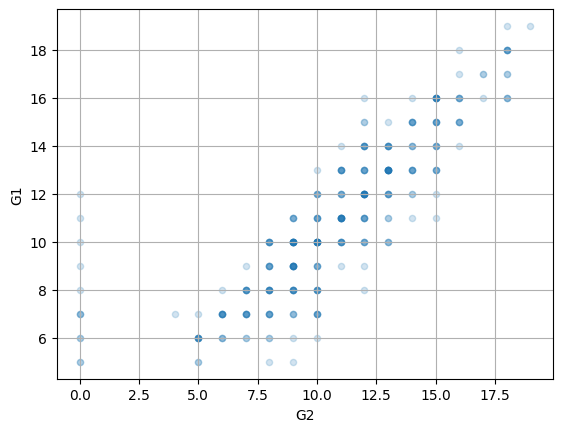

In [23]:
# More Visualizations (of training set)

# creates a scatterplot of training set
X_train.plot(kind="scatter", x="G2", y="G1", grid=True, alpha=0.2)
plt.show() # G1 and G2 line up well, student success in 1 is a good indicator of success in the other

<Axes: xlabel='G3', ylabel='G1'>

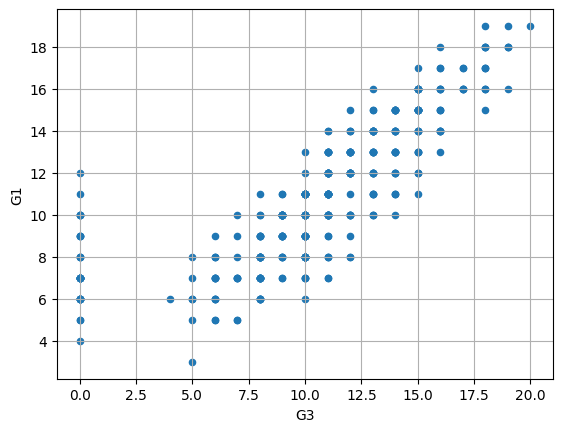

In [25]:
# Create the scatter plot
students.plot(kind="scatter", x="G3", y='G1', grid=True)  

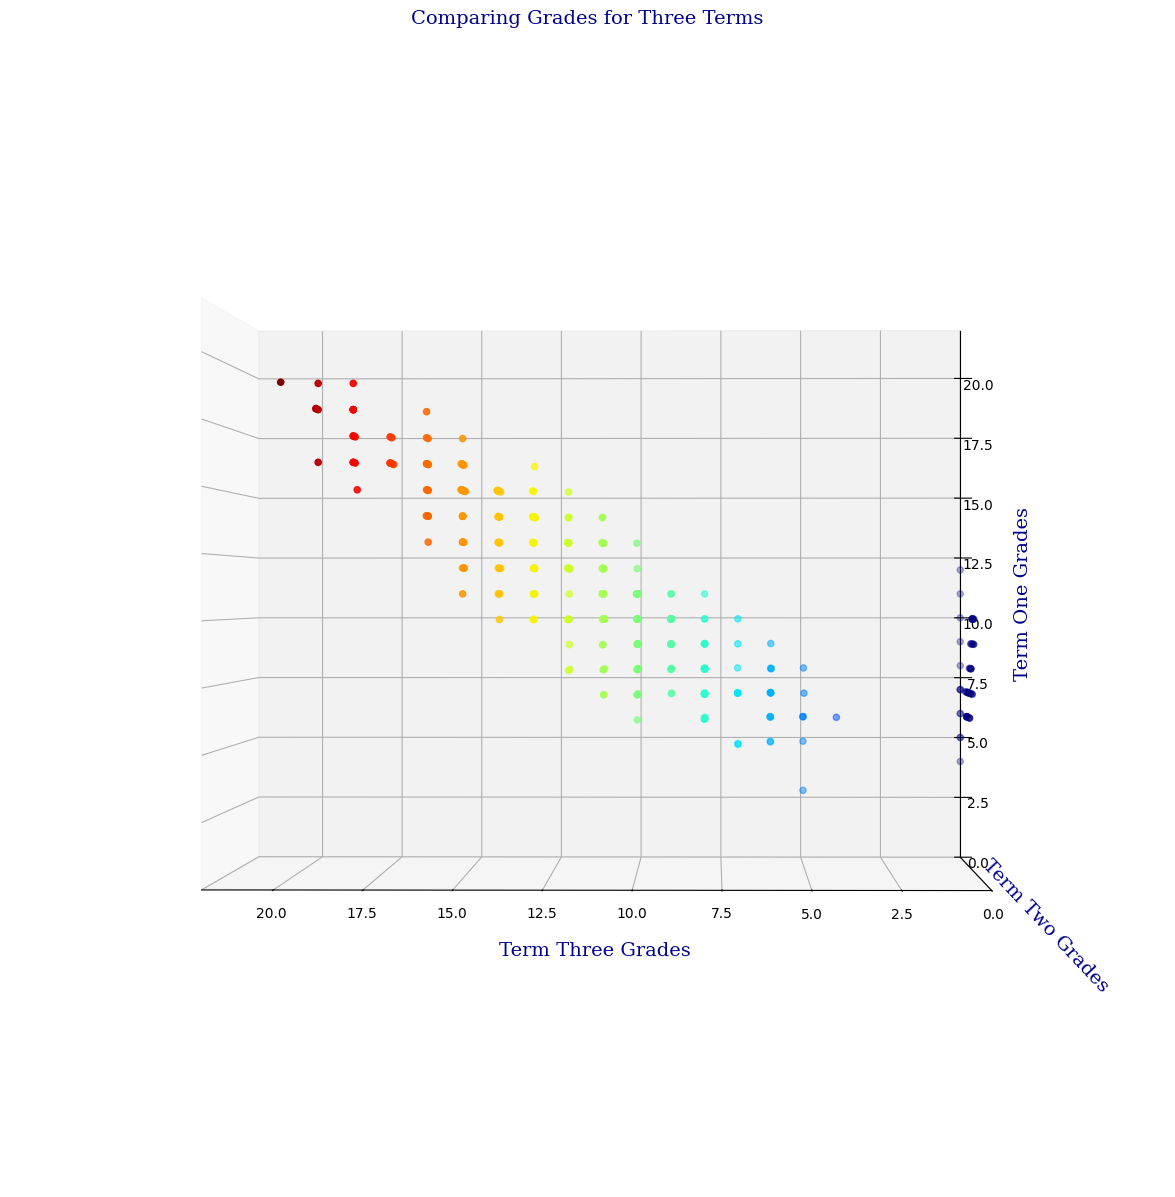

In [26]:
# Making plot with 4 subplots

# create the features
G1 = students['G1']
G2 = students['G2']
target = students['G3']
fig = plt.figure(figsize=[15, 15])
font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 14,
        }
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 8,
        }
#  First subplot
plt.subplots_adjust(hspace= -10)
ax = fig.add_subplot(projection='3d')
ax.view_init(0, 91)
ax.set_title('Comparing Grades for Three Terms', fontdict=font)
ax.scatter3D(target, G2, G1, c=target, cmap='jet');
ax.set_xlabel('Term Three Grades',fontdict=font)
ax.set_ylabel('Term Two Grades',fontdict=font)
ax.set_yticks([])
ax.set_zlabel('Term One Grades',fontdict=font)
ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.set_zlim(0, 22)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20
# plt.show()
plt.savefig('terms1.jpg')

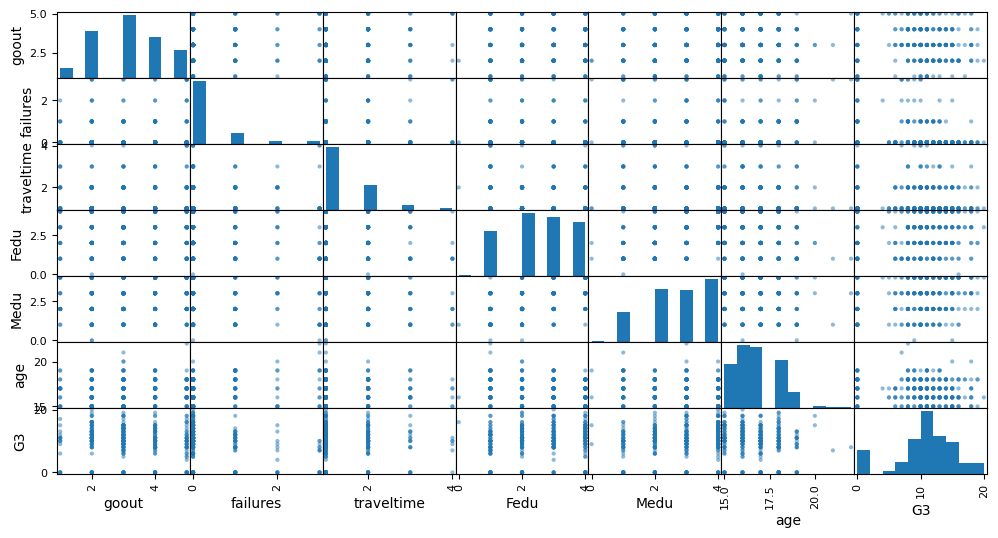

In [27]:
# plot matrix
# relevant numeric attributes from the training data
col_attributes = ['goout', 'failures', 'traveltime', 'Fedu', 'Medu', 'age']# combine training features and target into DataFrame
combined_df = pd.concat([X_train[col_attributes], y_train], axis=1)
# plots scatterplots and histograms
scatter_matrix(combined_df, figsize=(12, 6))
plt.show()

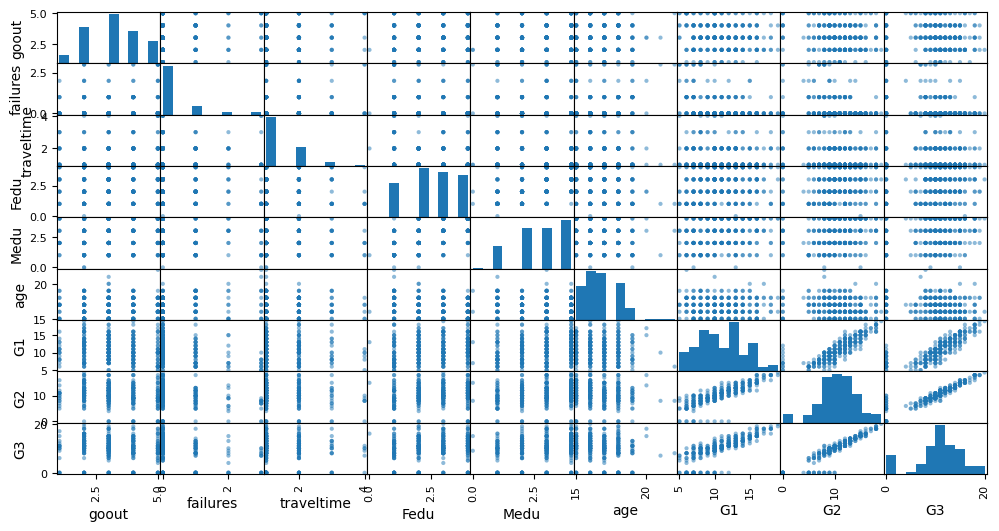

In [28]:
col_attributes = ['goout', 'failures', 'traveltime', 'Fedu', 'Medu', 'age','G1','G2']# combine training features and target into DataFrame
combined_df = pd.concat([X_train[col_attributes], y_train], axis=1)
# plots scatterplots and histograms
scatter_matrix(combined_df, figsize=(12, 6))
plt.show()

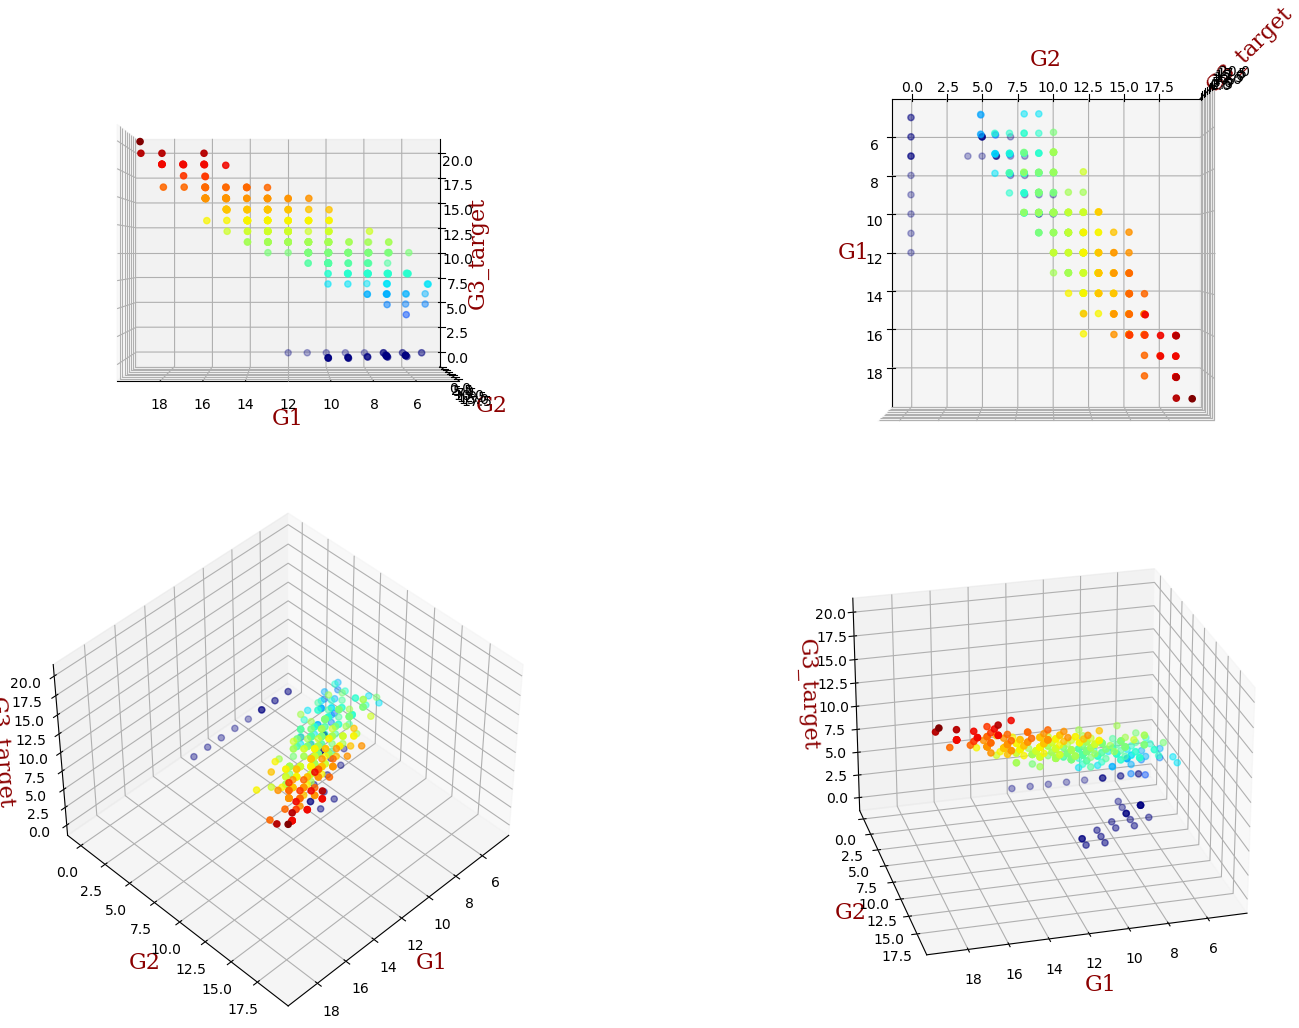

In [246]:
# Making plot with 4 subplots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# create the features
G1 = X_train['G1']
G2 = X_train['G2']
target = y_train
fig = plt.figure(figsize=[18, 10])
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
#  First subplot
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.view_init(0, 90)
ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)

# Second subplot
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.view_init(90, 0)
ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)

# Third subplot
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.view_init(45, 45)

ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)

# Fourth subplot
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.view_init(25, 75)
ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.show()

In [249]:
# 3 Correlations
# selecting numeric attributes

col_attributes_2 = ['G1','G2','absences_G1', 'absences_G2','failures','famrel','goout','Dalc','Walc','health','freetime','age','Medu','Fedu','traveltime','studytime']
# creating a new combined DataFrame
combined_df = pd.concat([X_train[col_attributes_2], y_train], axis=1)
# making correlations matrix
corr_matrix = combined_df.corr()
corr_matrix["G3"].sort_values(ascending=False)

G3             1.000000
G2             0.907924
G1             0.791559
Medu           0.215968
studytime      0.138200
Fedu           0.135265
absences_G2    0.084984
famrel         0.069409
absences_G1    0.032266
freetime      -0.015244
Walc          -0.057363
Dalc          -0.064698
health        -0.068857
goout         -0.106024
traveltime    -0.106752
age           -0.134519
failures      -0.373769
Name: G3, dtype: float64

## Data Preparation

### Feature Selection
Listing out columns for the transformers into:
- **numeric_columns**
- **categorical_columns**
- **ordinal_columns**

In [101]:
#1 Create lists of features that will we use
# these are based on the high positive and negative correlations in the data exploration section
numeric_columns = ['goout','failures','traveltime','Fedu','Medu','age','G1','G2']
ordinal_columns = ['Mjob']
categorical_columns = ['sex','address','paid','higher','romantic']


### Custom Transformer

In [102]:
# Custom transformer to drop grades from G1 and G2


# Making the class
class NumericDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_grades=True):
        self.drop_grades = drop_grades
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.drop_grades:
            X=X.drop(['G1','G2'], axis=1)
            return X
        else:
            return X


### Making Data Pipelines
These will apply the same transformations to new data and transform the data based upon the three column types (numeric, categorical, and ordinal). They will also separate the data into versions with and without the G1 and G2 columns.

In [103]:
numeric_pipeline_with_grades = make_pipeline (
    SimpleImputer(strategy="median").set_output(transform="pandas"),
    NumericDataTransformer(drop_grades=False),
    StandardScaler())

In [104]:
numeric_pipeline_without_grades = make_pipeline (
    SimpleImputer(strategy="median").set_output(transform="pandas"),
    NumericDataTransformer(),
    StandardScaler())

In [105]:
categorical_data_pipeline = make_pipeline (
    OneHotEncoder())

In [106]:
ordinal_data_pipeline = make_pipeline (
    OrdinalEncoder())

In [107]:

column_transformer_with_grades = ColumnTransformer ([
    ('num', numeric_pipeline_with_grades, numeric_columns),
    ('cat', categorical_data_pipeline, categorical_columns),
    ('ord', ordinal_data_pipeline, ordinal_columns)
])


In [108]:
column_transformer_without_grades = ColumnTransformer ([
    ('num', numeric_pipeline_without_grades, numeric_columns),
    ('cat', categorical_data_pipeline, categorical_columns),
    ('ord', ordinal_data_pipeline, ordinal_columns)
])


In [109]:
# using fit_transform to transform the X_train data with and without G1 and G2 data

X_train_transformed_with_grades = column_transformer_with_grades.fit_transform(X_train)

In [110]:
X_train_transformed_without_grades = column_transformer_without_grades.fit_transform(X_train)

In [111]:
X_train_transformed_with_grades[0]

array([-0.14439599, -0.45674383, -0.62577865,  0.42320737,  0.24643712,
       -0.58639605,  0.33205033,  0.62616324,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  3.        ])

In [112]:
X_train_transformed_without_grades[0]

array([-0.14439599, -0.45674383, -0.62577865,  0.42320737,  0.24643712,
       -0.58639605,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  3.        ])

## Regression Models
I run 4 regression models:
- Linear Regression
- Support Vector Machine (SVM) Regression
- Lasso Regression
- Ridge Regression
- Stacking Ensemble Method

I then examine each of them with cross-validation (10 folds) and look at the root mean squared (RMSE) value to see which ones are closer to the target values.

In [113]:
# Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed_with_grades, y_train)
lin_reg.fit(X_train_transformed_without_grades, y_train)


LinearRegression()

In [114]:
# Linear Regression Cross-Validation

cv_scores_lin_reg_with_grades = -cross_val_score(lin_reg, X_train_transformed_with_grades, y_train,
                                                 scoring="neg_root_mean_squared_error", cv=10)
cv_scores_lin_reg_without_grades = -cross_val_score(lin_reg, X_train_transformed_without_grades, y_train,
                                                    scoring="neg_root_mean_squared_error", cv=10)

In [115]:
# I am seeing all the folds to get a better interpretation
print(cv_scores_lin_reg_with_grades)
print(cv_scores_lin_reg_without_grades)

[2.27576843 1.99238001 1.17438908 1.80244305 1.80035618 1.85556344
 1.74808014 2.60312423 1.877195   1.81849448]
[4.77524591 4.71423399 3.16444413 4.38546778 4.45460839 4.65933201
 4.86762658 4.32756879 3.8004875  3.66659176]


In [116]:
# Linear Regression Mean Cross-Validation Score
rmse_lin_reg_with_grades = cv_scores_lin_reg_with_grades.mean()
print(rmse_lin_reg_with_grades)
rmse_lin_reg_without_grades = cv_scores_lin_reg_without_grades.mean()
print(rmse_lin_reg_without_grades)

1.8947794025702946
4.28156068255823


In [73]:
#  Lasso Regression

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_transformed_with_grades, y_train)
lasso_reg.fit(X_train_transformed_without_grades, y_train)


Lasso(alpha=0.1)

In [117]:
# Lasso Cross-Validation

cv_scores_lasso_with_grades = -cross_val_score(lasso_reg, X_train_transformed_with_grades, y_train,
                                                scoring="neg_root_mean_squared_error", cv=10)
cv_scores_lasso_without_grades = -cross_val_score(lasso_reg, X_train_transformed_without_grades, y_train,
                                                  scoring="neg_root_mean_squared_error", cv=10)

In [118]:
# trying to make the interpretation easier by seeing all of the folds
# I think this is the best one. The mean is lower for both and the individual scores for each fold are typically better (save 3 in the lin_reg).
print(cv_scores_lasso_with_grades)
print(cv_scores_lasso_without_grades)

[2.32225485 1.88137023 1.13285627 1.83995235 1.55216338 1.88557788
 1.7101523  2.63422729 1.86714236 1.83270543]
[4.64285041 4.72759192 3.18719016 4.16424428 4.01628191 4.78522208
 4.90455646 4.35947754 3.86742454 3.82702836]


In [119]:
pd.Series(cv_scores_lasso_with_grades).describe()

count    10.000000
mean      1.865840
std       0.402910
min       1.132856
25%       1.740791
50%       1.853547
75%       1.884526
max       2.634227
dtype: float64

In [120]:
pd.Series(cv_scores_lasso_without_grades).describe()

count    10.000000
mean      4.248187
std       0.540175
min       3.187190
25%       3.904639
50%       4.261861
75%       4.706407
max       4.904556
dtype: float64

In [121]:
# Lasso Cross-Validation Score
rmse_lasso_with_grades = cv_scores_lasso_with_grades.mean()
print(rmse_lasso_with_grades)
rmse_lasso_without_grades = cv_scores_lasso_without_grades.mean()
print(rmse_lasso_without_grades)

1.8658402340525817
4.248186766559097


In [122]:
#  Support Vector Machine (SVM) Regression

svm_reg = SVR()

svm_reg.fit(X_train_transformed_with_grades, y_train)
svm_reg.fit(X_train_transformed_without_grades, y_train)


SVR()

In [123]:
# SVM Cross-Validation

cv_scores_svm_with_grades = -cross_val_score(svm_reg, X_train_transformed_with_grades, y_train,
                                             scoring="neg_root_mean_squared_error", cv=10)
cv_scores_svm_without_grades = -cross_val_score(svm_reg, X_train_transformed_without_grades, y_train,
                                                scoring="neg_root_mean_squared_error", cv=10)

In [124]:
# trying to make the interpretation easier by seeing all of the folds
print(cv_scores_svm_with_grades)
print(cv_scores_svm_without_grades)

[3.18290615 2.67514747 1.50033014 2.40887796 1.95961236 2.73473356
 2.24883769 3.05681685 2.48068997 2.55238372]
[4.86714037 4.64286848 3.3421397  4.34145755 3.48852171 4.82158251
 4.93364672 4.3885867  3.71479383 3.96832156]


In [125]:
# SVM Mean Cross-Validation Score
rmse_svm_with_grades = cv_scores_svm_with_grades.mean()
print(rmse_svm_with_grades)
rmse_svm_without_grades = cv_scores_svm_without_grades.mean()
print(rmse_svm_without_grades)

2.4800335868771306
4.250905913726104


In [126]:
# Ridge Regression

ridge_reg = Ridge()

ridge_reg.fit(X_train_transformed_with_grades, y_train)
ridge_reg.fit(X_train_transformed_without_grades, y_train)

Ridge()

In [127]:
# Ridge Regression Cross-Validation

cv_scores_ridge_reg_with_grades = -cross_val_score(ridge_reg, X_train_transformed_with_grades, y_train,
                                                   scoring="neg_root_mean_squared_error", cv=10)
cv_scores_ridge_reg_without_grades = -cross_val_score(ridge_reg, X_train_transformed_without_grades, y_train,
                                                      scoring="neg_root_mean_squared_error", cv=10)

In [128]:
# trying to make the interpretation easier by seeing all of the folds
print(cv_scores_ridge_reg_with_grades)
print(cv_scores_ridge_reg_without_grades)

[2.27692937 1.99038908 1.16993403 1.79874973 1.80195356 1.85300648
 1.74663134 2.60609019 1.87392125 1.81869956]
[4.77060374 4.71461605 3.16496779 4.37850872 4.42897991 4.6597158
 4.86944929 4.32716533 3.80039719 3.66992236]


In [129]:
# Ridge Regression Mean Cross-Validation Score
rmse_ridge_reg_with_grades = cv_scores_ridge_reg_with_grades.mean()
print(rmse_svm_with_grades)

rmse_ridge_reg_without_grades = cv_scores_ridge_reg_without_grades.mean()
print(rmse_svm_without_grades)

2.4800335868771306
4.250905913726104


In [136]:
# Stacked Ensemble Method to try to improve the scores

stacking_model = StackingRegressor(
    estimators=[
        ('ridge', Ridge(random_state=42)),
        ('lasso', Lasso(random_state=42)),
        ('svr', SVR()),
        ('linear', LinearRegression())
    ],
    cv=10
)

stacking_model.fit(X_train_transformed_with_grades, y_train)
stacking_model.fit(X_train_transformed_without_grades, y_train)


StackingRegressor(cv=10,
                  estimators=[('ridge', Ridge(random_state=42)),
                              ('lasso', Lasso(random_state=42)), ('svr', SVR()),
                              ('linear', LinearRegression())])

In [137]:
# Ridge Regression Cross-Validation

cv_scores_stacking_model_with_grades = -cross_val_score(stacking_model, X_train_transformed_with_grades, y_train,
                                                        scoring="neg_root_mean_squared_error", cv=10)
cv_scores_stacking_model_without_grades = -cross_val_score(stacking_model, X_train_transformed_without_grades, y_train,
                                                           scoring="neg_root_mean_squared_error", cv=10)

In [138]:
rmse_stacking_model_with_grades = cv_scores_stacking_model_with_grades.mean()
print(rmse_stacking_model_with_grades)

rmse_stacking_model_without_grades = cv_scores_stacking_model_without_grades.mean()
print(rmse_stacking_model_without_grades)

1.8775391034726525
4.215373590201667


## Fine-Tune the System
Include a gridsearch to find the best parameters?
Still editing this section for SVM model

In [ ]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {'C': [0.1, 1, 10, 100],
              'epsilon': [0.01, 0.1, 1]}

grid_search = GridSearchCV(svm_reg, param_grid, verbose=1, cv=4)

grid_search_with = grid_search.fit(X_train_transformed_with_grades, y_train)
grid_search_without = grid_search.fit(X_train_transformed_without_grades, y_train)

parameters_with_grades = grid_search_with.best_params_
parameters_without_grades = grid_search_without.best_params_


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits


In [331]:
print(grid_search_with.best_score_)

0.08232532446407007


In [332]:
print(grid_search_without.best_score_)

0.08232532446407007


In [336]:
final_model_with = grid_search_with.best_estimator_
final_model_without = grid_search_without.best_estimator_

## Performance Measurements with Test Set
These will provide the predictions and the RMSE and R2 scores for the models to see which ones have the best predictions.

I am still working on this section.

In [338]:
from sklearn.metrics import mean_squared_error, r2_score
# this is fitting the gridsearch model, but I dont think that it is the best. I am going to fit the lasso model after this.
final_model_with.fit(X_train_transformed_with_grades, y_train)

X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)

best_pred = final_model_with.predict(X_test_transformed_with_grades)

rmse_with_grades = mean_squared_error(y_test, best_pred, squared=False)

r2_with_grades = r2_score(y_test, best_pred)

In [340]:
final_model_without.fit(X_train_transformed_without_grades, y_train)

X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

best_pred_without = final_model_without.predict(X_test_transformed_without_grades)

rmse_without_grades = mean_squared_error(y_test, best_pred_without, squared=False)

r2_without_grades = r2_score(y_test, best_pred_without)

In [342]:
lasso_reg.fit(X_train_transformed_with_grades, y_train)

X_test_transform1_with_grades = column_transformer_with_grades.transform(X_test)

best_pred1 = lasso_reg.predict(X_test_transform1_with_grades)

rmse_with_grades1 = mean_squared_error(y_test, best_pred1, squared=False)

r2_with_grades1 = r2_score(y_test, best_pred1)

In [344]:
lasso_reg.fit(X_train_transformed_without_grades, y_train)

X_test_transform1_without_grades = column_transformer_without_grades.transform(X_test)

best_pred_without1 = lasso_reg.predict(X_test_transform1_without_grades)

rmse_without_grades1 = mean_squared_error(y_test, best_pred_without1, squared=False)

r2_without_grades1 = r2_score(y_test, best_pred_without1)

In [346]:
lin_reg.fit(X_train_transformed_with_grades, y_train)

X_test_transform2_with_grades = column_transformer_with_grades.transform(X_test)

best_pred2 = lin_reg.predict(X_test_transform2_with_grades)

rmse_with_grades2 = mean_squared_error(y_test, best_pred2, squared=False)

r2_with_grades2 = r2_score(y_test, best_pred2)

In [348]:
lin_reg.fit(X_train_transformed_without_grades, y_train)

X_test_transform2_without_grades = column_transformer_without_grades.transform(X_test)

best_pred_without2 = lin_reg.predict(X_test_transform2_without_grades)

rmse_without_grades2 = mean_squared_error(y_test, best_pred_without2, squared=False)

r2_without_grades2 = r2_score(y_test, best_pred_without2)

In [352]:
print(rmse_with_grades2)
print(r2_with_grades2)

2.1673878279532715
0.7709066487217582


In [368]:
print(rmse_without_grades2)
print(r2_without_grades2)

4.261603969280346
0.11430253470959595


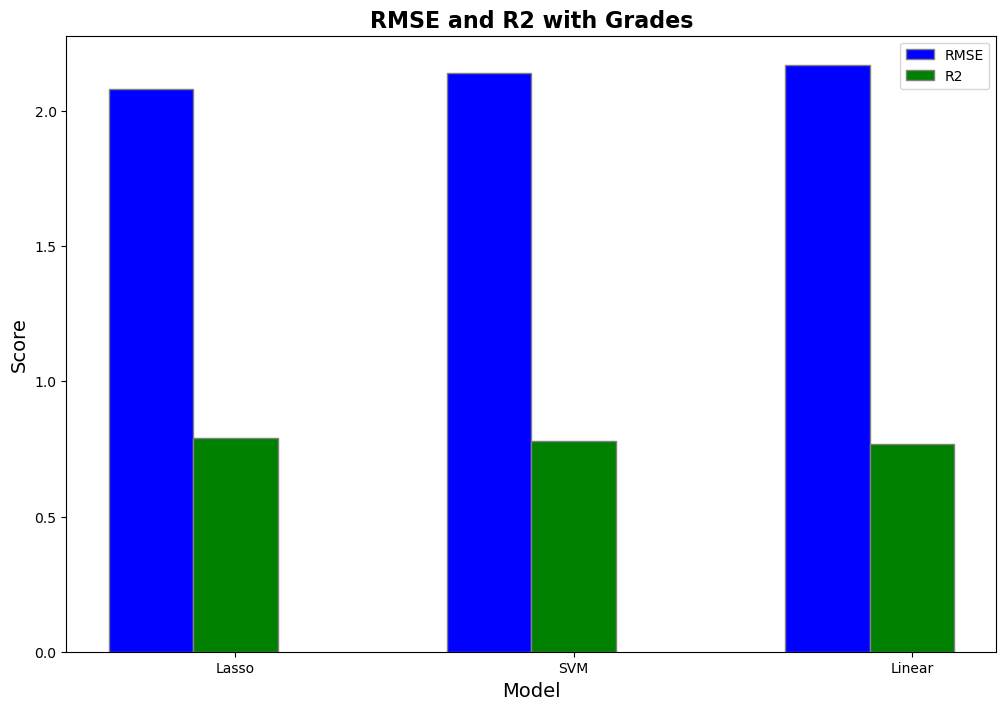

In [366]:
# categories = ['Lasso RMSE', 'Lasso R2', 'SVM RMSE', 'SVM R2','Linear RMSE','Linear R2']
# score = []

# # Vertical bar chart
# plt.bar(categories, score)
# 
# plt.xlabel('RMSE and R2')
# plt.ylabel('Scores')
# plt.show()


barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
plt.title('RMSE and R2 with Grades', fontweight ='bold', fontsize=16)
RMSE = [2.08, 2.14, 2.17] 
R2 = [0.79, 0.78,  0.77] 

br1 = np.arange(len(RMSE)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, RMSE, color ='b', width = barWidth, 
        edgecolor ='grey', label ='RMSE') 
plt.bar(br2, R2, color ='g', width = barWidth, 
        edgecolor ='grey', label ='R2') 

plt.xlabel('Model', fontsize = 14) 
plt.ylabel('Score', fontsize = 14) 
plt.xticks([r + barWidth for r in range(len(RMSE))], 
        ['Lasso', 'SVM', 'Linear'])

plt.legend()
plt.show() 


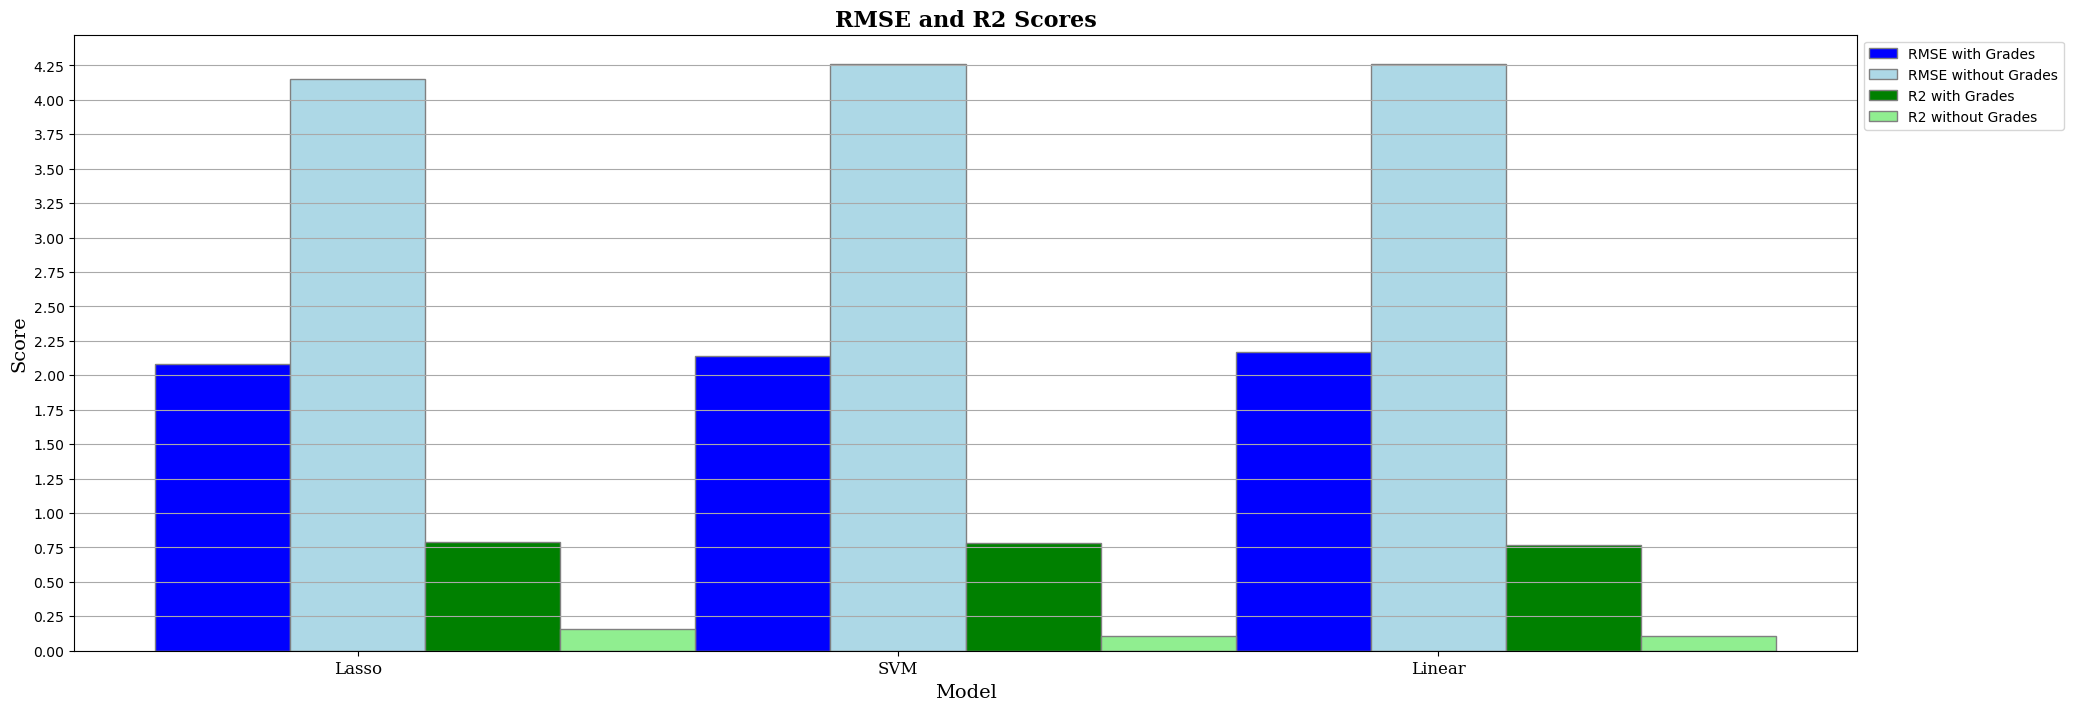

In [452]:
barWidth = 0.25
fig = plt.subplots(figsize =(23, 8)) 

RMSE_with = [2.08, 2.14, 2.17] 
R2_with = [0.79, 0.78,  0.77] 
RMSE = [4.15, 4.26, 4.26] 
R2 = [0.16, 0.11, 0.11] 

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }
plt.title('RMSE and R2 Scores', fontweight ='bold', fontdict=font, fontsize=16)
br1 = np.arange(len(RMSE)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, RMSE_with, color ='b', width = barWidth, 
        edgecolor ='grey', label ='RMSE with Grades') 
plt.bar(br2, RMSE, color ='lightblue', width = barWidth, 
        edgecolor ='grey', label ='RMSE without Grades') 
plt.bar(br3, R2_with, color ='g', width = barWidth, 
        edgecolor ='grey', label ='R2 with Grades') 
plt.bar(br4, R2, color ='lightgreen', width = barWidth, 
        edgecolor ='grey', label ='R2 without Grades') 

plt.xlabel('Model', fontsize = 14, fontdict=font) 
plt.ylabel('Score', fontsize = 14, fontdict=font)
plt.yticks(np.arange(0, 4.5, 0.25))
plt.xticks([r + barWidth for r in range(len(RMSE))], 
        ['Lasso', 'SVM', 'Linear'], fontdict=font2)
plt.grid(axis='y', color = 'darkgray')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show() 
plt.savefig("rmser2.png")

In [454]:
# Gridsearch/SVM has regular names, Lasso has 1 at the end

print("Lasso model RMSE with grades: ", rmse_with_grades1)
print("SVM model RMSE with grades: ", rmse_with_grades)
print("Linear model RMSE with grades: ", rmse_with_grades2)

print("Lasso model r2 with grades: ", r2_with_grades1)
print("SVM model r2 with grades: ", r2_with_grades)
print("Linear model r2 with grades: ", r2_with_grades2)

print("Lasso model RMSE without grades: ", rmse_without_grades1)
print("SVM model RMSE without grades: ", rmse_without_grades)
print("Linear model RMSE without grades: ", rmse_without_grades2)

print("Lasso model r2 without grades: ", r2_without_grades1)
print("SVM model r2 without grades: ", r2_without_grades)
print("Linear model r2 without grades: ", r2_without_grades2)


Lasso model RMSE with grades:  2.0817393301366742
SVM model RMSE with grades:  2.1387153062956163
Linear model RMSE with grades:  2.1673878279532715
Lasso model r2 with grades:  0.7886550281019358
SVM model r2 with grades:  0.7769279386882111
Linear model r2 with grades:  0.7709066487217582
Lasso model RMSE without grades:  4.145714505193224
SVM model RMSE without grades:  4.260759425625859
Linear model RMSE without grades:  4.261603969280346
Lasso model r2 without grades:  0.16181862280629966
SVM model r2 without grades:  0.11465354623530966
Linear model r2 without grades:  0.11430253470959595


**Summary**
None of the models are great, especially without the grades from G1 and G2. However, the Lasso model is the best option, though as shown in the final 
code block it is only marginally better than the svm best model option.
In addition, the R2 for the Lasso and SVM with grades is fairly good even though the root mean square error is high.